In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy import stats
from collections import defaultdict
import shap
import datetime
import pickle

In [2]:
df = pd.read_pickle('../data/Fendi_refined.pkl')

In [3]:
brand = 'Fendi'

In [4]:
max_date = max(df['sc_date'])- datetime.timedelta(days=30)

# Model No 1

## Labeling

In [5]:
df = df[df.apply(lambda x: x['sc_date'] == x['sc_date_first_date'], axis = 1)]

In [6]:
def labelling_model_1(row):
    if row['lifetime'] <= 30 and row['status'] == 'Complete':
        return 1.0
    elif row['lifetime'] > 30:
        return 0.0
    else:
        return None

In [7]:
df['label'] = df.apply(lambda x: labelling_model_1(x), axis = 1)

In [8]:
count_df = df[df['sc_date_first_date'] < max_date]

In [9]:
count_df['label'].value_counts()

1.0    22
0.0    17
Name: label, dtype: int64

In [10]:
df = df[-df['label'].isnull()]

In [11]:
df.columns

Index(['bags_brand', 'id', 'sc_date', 'bags_color', 'bags_condition',
       'materials_list', 'bags_price_refined', 'sold_price_refined',
       'retail_price_refined', 'likes', 'size', 'search_tradesy_fendi',
       'search_fendi', 'search_kan_i', 'sc_date_last_date',
       'sc_date_first_date', 'lifetime', 'status', 'number_similar',
       'avg_similar', 'original_to_avg', 'price_to_retail', 'price_percentile',
       'label'],
      dtype='object')

In [12]:
if len(set(df['size'])) > 1: 
    cols = list(set(df.columns) - {'bags_brand', 'id', 'sc_date', 'sold_price_refined', 'likes', 'sc_date_first_date',
                                    'sc_date_last_date', 'lifetime', 'status', 'price_percentile', 'label'})
    ordinal_cols = ['bags_condition']
    categorical_cols = ['bags_color', 'materials_list', 'size']
else:
    cols = list(set(df.columns) - {'bags_brand', 'id', 'sc_date', 'sold_price_refined', 'likes', 'sc_date_first_date',
                                    'sc_date_last_date', 'lifetime', 'status', 'price_percentile', 'label', 'size'})
    ordinal_cols = ['bags_condition']
    categorical_cols = ['bags_color', 'materials_list']

In [13]:
df_train, df_test = train_test_split(df[cols + ['label']], test_size=0.2, random_state=41)

In [14]:
def loo(feature_value, label_value, feature_dict):
    if len(feature_dict[feature_value]) == 1 or feature_value is None:
        return (sum(feature_dict['all']) - label_value) / (len(feature_dict['all']) - 1)
    else:
        return (sum(feature_dict[feature_value]) - label_value) / (len(feature_dict[feature_value]) - 1)

In [15]:
def LOO_encoder(train_df, test_df, categorical_cols, label_col):
    for feature in categorical_cols:
        feature_dict = defaultdict(list)
        for i, row in train_df.iterrows():
            feature_dict[row[feature]].append(row[label_col])
            feature_dict['all'].append(row[label_col])
        train_df['%s_loo'%feature] = train_df.apply(lambda x: loo(x[feature], x[label_col], feature_dict), axis = 1)
        test_df['%s_loo'%feature] = test_df.apply(lambda x: loo(x[feature], x[label_col], feature_dict), axis = 1)
    return train_df, test_df

In [16]:
def OH_encoder(train_df, test_df, ordinal_cols):
    for feature in ordinal_cols:
        feature_states = list(set(train_df[feature]).union(set(test_df[feature])))[:-1]
        for state in feature_states:
            train_df['%s_%s'%(feature,state)] = train_df[feature].map(lambda x: int(x == state))
            test_df['%s_%s'%(feature,state)] = test_df[feature].map(lambda x: int(x == state))
    return train_df, test_df

In [17]:
df_train, df_test = LOO_encoder(df_train, df_test, categorical_cols, 'label')

In [18]:
df_train, df_test = OH_encoder(df_train, df_test, ordinal_cols)

In [19]:
cols = ['label'] + list(set(df_train.columns) - {'bags_color', 'bags_condition', 'materials_list', 'size', 'label'})
df_train = df_train[cols]
df_test = df_test[cols]

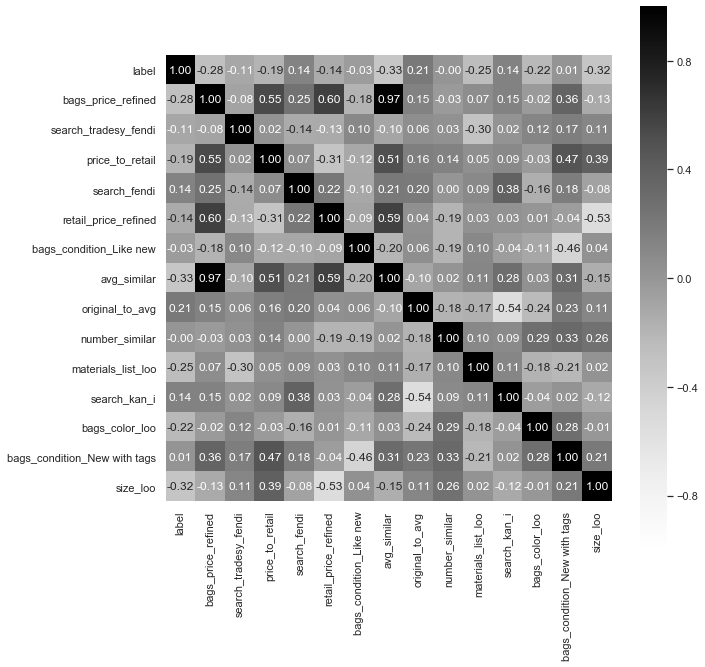

In [20]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1)
sns.heatmap(df_train[cols].corr(), annot = True, square=True, fmt='.2f', vmin=-1, vmax=1, center= 0, cmap= 'Greys')


In [21]:
if brand == 'Chanel':
    for column in ['retail_price_refined', 'avg_similar']:
        cols.remove(column)
elif brand == 'Louis Vuitton':
    for column in ['avg_similar']:
        cols.remove(column)
elif brand == 'Gucci':
    for column in ['avg_similar']:
        cols.remove(column)
elif brand == 'Saint Laurent':
    for column in ['avg_similar', 'bags_price_refined']:
        cols.remove(column)
elif brand == 'Fendi':
    for column in ['bags_price_refined']:
        cols.remove(column)

In [22]:
df['label'].sum() / df.shape[0]

0.5952380952380952

# SVM

In [23]:
if df['label'].sum() / df.shape[0] > 0.5:
    sample_size = df_train[df_train['label'] == 0].shape[0]
    df_train = df_train[df_train['label'] == 0].append(df_train[df_train['label'] == 1].\
                                                   sample(n=sample_size, random_state=40))
else:
    sample_size = df_train[df_train['label'] == 1].shape[0]
    df_train = df_train[df_train['label'] == 1].append(df_train[df_train['label'] == 0].\
                                                   sample(n=sample_size, random_state=40))    

In [24]:
from sklearn import svm
X = df_train[cols[1:]]
y = df_train['label']
svm_clf = svm.SVC(probability=True)
svm_clf.fit(X, y)

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [25]:
df_test['svm_pred'] = svm_clf.predict(df_test[cols[1:]])
df_test['svm_prob'] = [item[0] for item in svm_clf.predict_proba(df_test[cols[1:]])]
df_test['svm_prob_false'] = [item[1] for item in svm_clf.predict_proba(df_test[cols[1:]])]

In [26]:
print(df_test[df_test.apply(lambda x: x['label'] == 1 and x['svm_pred'] == 1, axis = 1)].shape[0])
print(df_test[df_test.apply(lambda x: x['label'] == 1 and x['svm_pred'] == 0, axis = 1)].shape[0])
print(df_test[df_test.apply(lambda x: x['label'] == 0 and x['svm_pred'] == 1, axis = 1)].shape[0])
print(df_test[df_test.apply(lambda x: x['label'] == 0 and x['svm_pred'] == 0, axis = 1)].shape[0])

7
0
2
0


# Logistic Regression

In [27]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression().fit(X, y)

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.


In [28]:
df_test['lr_pred'] = lr_clf.predict(df_test[cols[1:]])
df_test['lr_prob'] = [item[0] for item in lr_clf.predict_proba(df_test[cols[1:]])]
df_test['lr_prob_false'] = [item[1] for item in lr_clf.predict_proba(df_test[cols[1:]])]

In [29]:
print(df_test[df_test.apply(lambda x: x['label'] == 1 and x['lr_pred'] == 1, axis = 1)].shape[0])
print(df_test[df_test.apply(lambda x: x['label'] == 1 and x['lr_pred'] == 0, axis = 1)].shape[0])
print(df_test[df_test.apply(lambda x: x['label'] == 0 and x['lr_pred'] == 1, axis = 1)].shape[0])
print(df_test[df_test.apply(lambda x: x['label'] == 0 and x['lr_pred'] == 0, axis = 1)].shape[0])

7
0
2
0


# XGBoost

In [30]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X, y)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [31]:
df_test['xgb_pred'] = model.predict(df_test[cols[1:]])
df_test['xgb_prob'] = [item[0] for item in model.predict_proba(df_test[cols[1:]])]
df_test['xgb_prob_false'] = [item[1] for item in model.predict_proba(df_test[cols[1:]])]

In [32]:
cols[1:]

['search_tradesy_fendi',
 'price_to_retail',
 'search_fendi',
 'retail_price_refined',
 'bags_condition_Like new',
 'avg_similar',
 'original_to_avg',
 'number_similar',
 'materials_list_loo',
 'search_kan_i',
 'bags_color_loo',
 'bags_condition_New with tags',
 'size_loo']

In [33]:
print(df_test[df_test.apply(lambda x: x['label'] == 1 and x['xgb_pred'] == 1, axis = 1)].shape[0])
print(df_test[df_test.apply(lambda x: x['label'] == 1 and x['xgb_pred'] == 0, axis = 1)].shape[0])
print(df_test[df_test.apply(lambda x: x['label'] == 0 and x['xgb_pred'] == 1, axis = 1)].shape[0])
print(df_test[df_test.apply(lambda x: x['label'] == 0 and x['xgb_pred'] == 0, axis = 1)].shape[0])

7
0
0
2


In [34]:
df_test['ensemble_prob'] = df_test.apply(lambda x: (x['svm_prob'] + x['lr_prob'] + x['xgb_prob']) / 3, axis = 1)
df_test['ensemble_pred'] = df_test['ensemble_prob'].apply(lambda x: 0 if x <= 0.5 else 1)
df_test['ensemble_prob_false'] = df_test['ensemble_prob'].apply(lambda x: 1-x)

In [35]:
print(df_test[df_test.apply(lambda x: x['label'] == 1 and x['ensemble_pred'] == 1, axis = 1)].shape[0])
print(df_test[df_test.apply(lambda x: x['label'] == 1 and x['ensemble_pred'] == 0, axis = 1)].shape[0])
print(df_test[df_test.apply(lambda x: x['label'] == 0 and x['ensemble_pred'] == 1, axis = 1)].shape[0])
print(df_test[df_test.apply(lambda x: x['label'] == 0 and x['ensemble_pred'] == 0, axis = 1)].shape[0])

0
7
1
1


In [36]:
with open('lifetime_models_spec.pkl', 'rb') as file:
    models_dict = pickle.load(file)
models_dict[brand] = model
with open('lifetime_models_spec.pkl', 'wb') as file:
    pickle.dump(models_dict,file)

# ROC curves

In [148]:
print(format('How to plot a ROC Curve in Python','*^82'))

import warnings
warnings.filterwarnings("ignore")

# load libraries
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

************************How to plot a ROC Curve in Python*************************


In [149]:
# Get predicted probabilities
y_score1 = df_test['svm_prob_false']
y_score2 = df_test['lr_prob_false']
y_score3 = df_test['xgb_prob_false']
y_score4 = df_test['ensemble_prob_false']

# Plot Receiving Operating Characteristic Curve
# Create true and false positive rates
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(df_test['label'], y_score1)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(df_test['label'], y_score2)
false_positive_rate3, true_positive_rate3, threshold3 = roc_curve(df_test['label'], y_score3)
false_positive_rate4, true_positive_rate4, threshold4 = roc_curve(df_test['label'], y_score4)
print('roc_auc_score for DecisionTree: ', roc_auc_score(df_test['label'], y_score1))
print('roc_auc_score for Logistic Regression: ', roc_auc_score(df_test['label'], y_score2))
print('roc_auc_score for XGBoost: ', roc_auc_score(df_test['label'], y_score3))
print('roc_auc_score for Ensemble: ', roc_auc_score(df_test['label'], y_score4))

roc_auc_score for DecisionTree:  0.39904862579281186
roc_auc_score for Logistic Regression:  0.6310782241014798
roc_auc_score for XGBoost:  0.9756871035940804
roc_auc_score for Ensemble:  0.9545454545454545


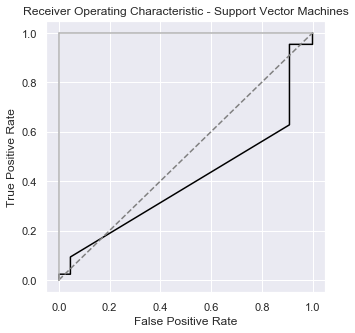

In [150]:
plt.subplots(1, figsize=(5,5))
plt.title('Receiver Operating Characteristic - Support Vector Machines')
plt.plot(false_positive_rate1, true_positive_rate1, color='Black')
plt.plot([0, 1], ls="--", color='Grey')
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

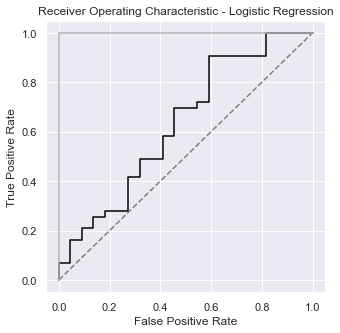

In [151]:
plt.subplots(1, figsize=(5,5))
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.plot(false_positive_rate2, true_positive_rate2, color='Black')
plt.plot([0, 1], ls="--", color='Grey')
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

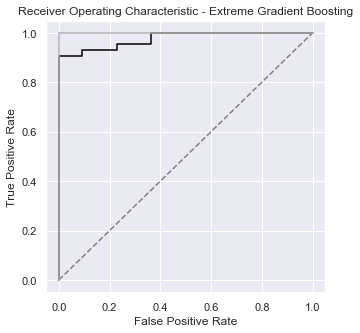

In [152]:
plt.subplots(1, figsize=(5,5))
plt.title('Receiver Operating Characteristic - Extreme Gradient Boosting')
plt.plot(false_positive_rate3, true_positive_rate3, color='Black')
plt.plot([0, 1], ls="--", color='Grey')
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [153]:
print(false_positive_rate3)
print(true_positive_rate3)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.09090909 0.09090909 0.22727273
 0.22727273 0.36363636 0.36363636 1.        ]
[0.         0.02325581 0.04651163 0.09302326 0.23255814 0.27906977
 0.44186047 0.48837209 0.90697674 0.90697674 0.93023256 0.93023256
 0.95348837 0.95348837 1.         1.        ]


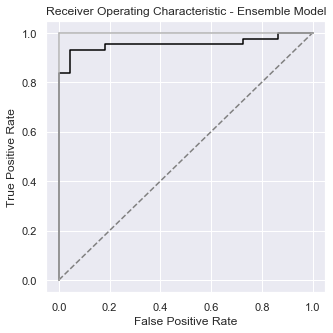

In [154]:
plt.subplots(1, figsize=(5,5))
plt.title('Receiver Operating Characteristic - Ensemble Model')
plt.plot(false_positive_rate4, true_positive_rate4, color='Black')
plt.plot([0, 1], ls="--", color='Grey')
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Shap

In [155]:
shap.initjs()

In [156]:
explainer = shap.TreeExplainer(model)

In [157]:
shap_values = explainer.shap_values(X.as_matrix())

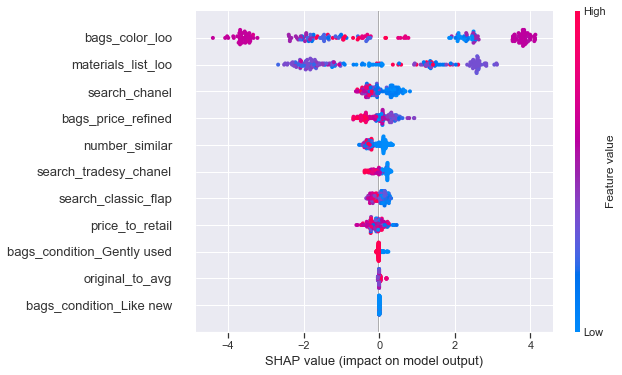

In [158]:
shap.summary_plot(shap_values, X)

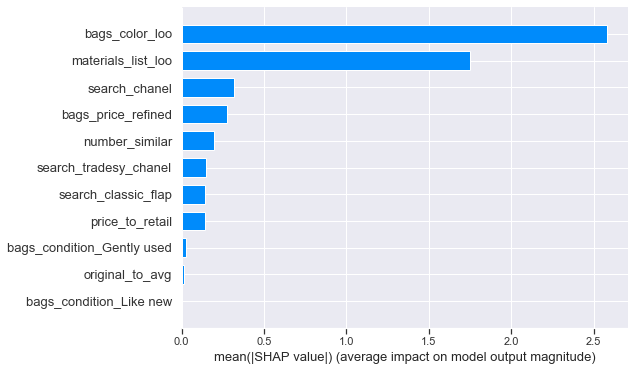

In [159]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [160]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [161]:
shap.force_plot(explainer.expected_value, shap_values, X)

In [162]:
X

,price_to_retail,number_similar,original_to_avg,bags_price_refined,search_tradesy_chanel,bags_color_loo,bags_condition_Like new,search_classic_flap,bags_condition_Gently used,materials_list_loo,search_chanel
131984,0.525000,1.0,1.000000,1365.0,46,0.593750,0,36,1,0.545455,43
14430,0.866667,1.0,1.000000,4680.0,67,0.637168,0,52,1,1.000000,53
121107,0.674545,23.0,1.408551,3710.0,0,0.637168,0,32,1,0.632653,43
132176,0.658621,1.0,1.000000,3820.0,46,0.500000,0,36,1,0.674419,43
121380,0.403902,5.0,0.732426,1915.0,0,0.637168,0,32,1,0.555556,43
...,...,...,...,...,...,...,...,...,...,...,...
64391,1.147368,1.0,1.000000,4360.0,44,0.692308,0,34,1,1.000000,42
5698,0.536047,1.0,1.000000,2305.0,43,0.615385,0,50,1,0.421053,100
38917,0.696082,6.0,0.934826,3550.0,0,0.411765,0,63,1,0.622449,42
132174,0.886842,4.0,1.247917,3370.0,46,0.692308,0,36,1,0.622449,43
